In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pylab
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa    
import glob
import tensorflow as tf
# from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers
import keras

%matplotlib inline


In [4]:
audio_data = []
labels = []
sampling_rate = []
file_names = []


In [6]:
#samplerate, data = wavfile.read("dataset/dog/1-30344-A.wav")
data, samplerate = librosa.load("dataset/001 - Dog bark/1-30226-A.ogg", sr=44000) # Downsample 44.1kHz to 8kHz

print(data.shape)
print(samplerate)


(220044,)
44000


In [7]:
time_sec = (len(data)/samplerate)
step = time_sec/len(data)
print(time_sec)
print(step)
i=0
time_divion=[]
while i<=time_sec-step:
    
    time_divion.append(i)
    i=i+step
# the fourth second step
four_sec_step_number = (4*len(time_divion))/time_sec
print(four_sec_step_number)

5.001
2.272727272727273e-05
176000.0


In [10]:
classes = []
label_number=0
audio_data = []
labels = []
sampling_rate = []
file_names = []
data = []
noisy_removed=[]
noise=[]
for filepath in glob.iglob('dataset/*'):
    
    #print(filepath[9:])
    
    #print(filepath)
    classes.append(filepath[8:])

print(classes)

for i in classes:
    print("the class = "+i+", the label = "+str(label_number))
    for j in glob.iglob('dataset/'+i+'/*'):
        #samplerate, data = wavfile.read(j)
        y, s = librosa.load(j, sr=44000) # Downsample 44.1kHz to 8kHz
        #reduced_noise = nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)
        #print(s)
        #print(j)
        data.append([y,label_number])
        #noise.append(y)
        labels.append(label_number)
        
    label_number = label_number + 1
print(len(labels))
#print(labels)

['001 - Dog bark', '002 - Rain', '003 - Sea waves', '004 - Baby cry', '005 - Clock tick', '006 - Person sneeze', '007 - Helicopter', '008 - Chainsaw', '009 - Rooster', '010 - Fire crackling']
the class = 001 - Dog bark, the label = 0
the class = 002 - Rain, the label = 1
the class = 003 - Sea waves, the label = 2
the class = 004 - Baby cry, the label = 3
the class = 005 - Clock tick, the label = 4
the class = 006 - Person sneeze, the label = 5
the class = 007 - Helicopter, the label = 6
the class = 008 - Chainsaw, the label = 7
the class = 009 - Rooster, the label = 8
the class = 010 - Fire crackling, the label = 9
400


In [11]:
import random

random.shuffle(data)
audio_data=[]
labels=[]
for i,j in data:
    audio_data.append(i)
    labels.append(j)
    


In [14]:
print(labels[12])

9


Text(0.5, 1.0, 'signal in real time')

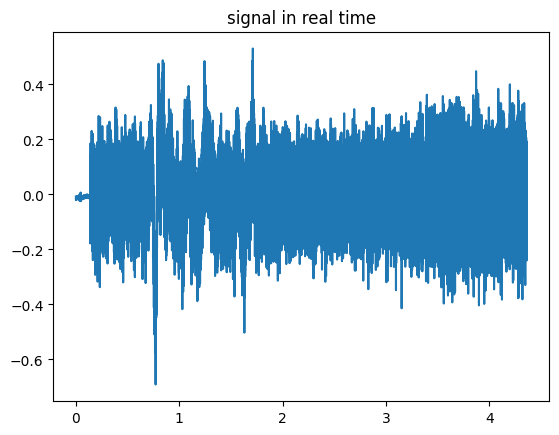

In [15]:
#save_path='dog_time.jpg'
plt.plot(time_divion[0:192000],audio_data[164][0:192000])
#plt.show()
plt.title('signal in real time')
#pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
#pylab.close()


In [17]:
example = random.randint(0,400)
hop_length = 512
oenv = librosa.onset.onset_strength(y=audio_data[164], sr=44000, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=44000,
                                      hop_length=hop_length)
print(tempogram.shape)
print(labels[example])

(384, 430)
5


In [18]:
example

194

Text(0.5, 1.0, 'Mel Spectrogram')

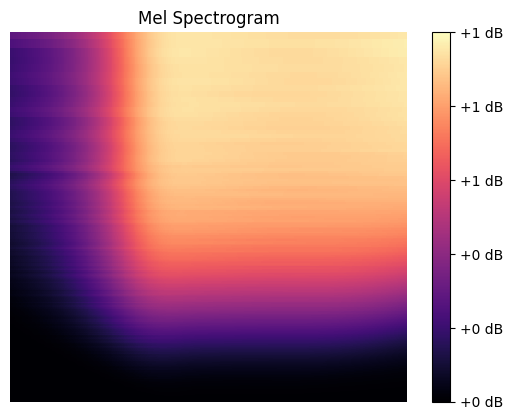

In [19]:

save_path = 'dog.jpg'

plt.axis('off') # no axis
librosa.display.specshow(tempogram, sr=44000, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
#pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
#pylab.close()

In [ ]:
# power.shape

(128, 430)

In [22]:
tempogram = []
for i in range (0,400):
    if i%100 == 0:
        print(i)
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=audio_data[i], sr=44000, hop_length=hop_length)
    tempogram_new = librosa.feature.tempogram(onset_envelope=oenv, sr=44000,
                                        hop_length=hop_length)
    #mel_feat = librosa.feature.tempogram(y=audio_data[i],sr=44000)
    #power = librosa.power_to_db(mel_feat)

    power=tempogram_new.reshape(-1,1)
  

    tempogram.append(power[:54656])
    if power.shape[0]<54656:
        print(i)
        print(power.shape)
    
tempogram =np.array(tempogram) 
tempogram.shape
    

0
100
200
300


(400, 54656, 1)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
tempogram=tempogram.reshape(400,-1)
scaler.fit(tempogram)
normalized_tempogram = scaler.transform(tempogram)

print(np.amax(tempogram))
print(np.amax(normalized_tempogram))



1.0
1.0000000000000002


In [24]:
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(normalized_tempogram, labels, test_size=0.20, random_state=1150)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.3625


In [26]:
features_convolution = np.reshape(normalized_tempogram,(400,128, -1,1))
#melspectrogram=melspectrogram.reshape(400,128, -1)
features_convolution.shape


(400, 128, 427, 1)

In [27]:
y=keras.utils.to_categorical(labels, num_classes=10, dtype='float32')


In [28]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=features_convolution.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#'''
#model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.2))

#'''
#'''
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#'''


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

#model.add(Dense(1000))#input_shape=features.shape[1:]
model.add(Dense(64))#input_shape=features.shape[1:]

model.add(Dense(10))
model.add(Activation('softmax'))
sgd = optimizers.SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

C:\Users\namit\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
history = model.fit(features_convolution, y,batch_size=8, epochs=30,validation_split=0.2)

Epoch 1/30
40/40 [==============================] - 9s 183ms/step - loss: 1.9924 - accuracy: 0.2656 - val_loss: 1.9484 - val_accuracy: 0.1375
Epoch 2/30
40/40 [==============================] - 7s 176ms/step - loss: 1.4737 - accuracy: 0.4094 - val_loss: 1.9152 - val_accuracy: 0.2875
Epoch 3/30
40/40 [==============================] - 7s 173ms/step - loss: 1.1952 - accuracy: 0.5500 - val_loss: 1.7742 - val_accuracy: 0.3625
Epoch 4/30
40/40 [==============================] - 7s 174ms/step - loss: 1.1296 - accuracy: 0.5437 - val_loss: 1.9173 - val_accuracy: 0.4375
Epoch 5/30
40/40 [==============================] - 7s 180ms/step - loss: 0.9460 - accuracy: 0.6500 - val_loss: 1.9751 - val_accuracy: 0.4625
Epoch 6/30
40/40 [==============================] - 7s 182ms/step - loss: 0.8182 - accuracy: 0.6719 - val_loss: 1.6418 - val_accuracy: 0.5250
Epoch 7/30
40/40 [==============================] - 7s 180ms/step - loss: 0.6794 - accuracy: 0.7281 - val_loss: 2.0810 - val_accuracy: 0.5125
Epoch 

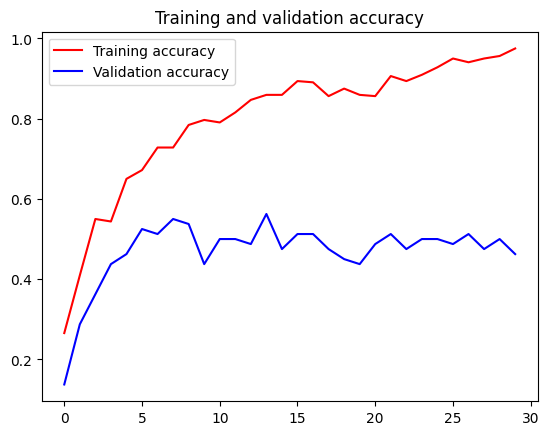

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()